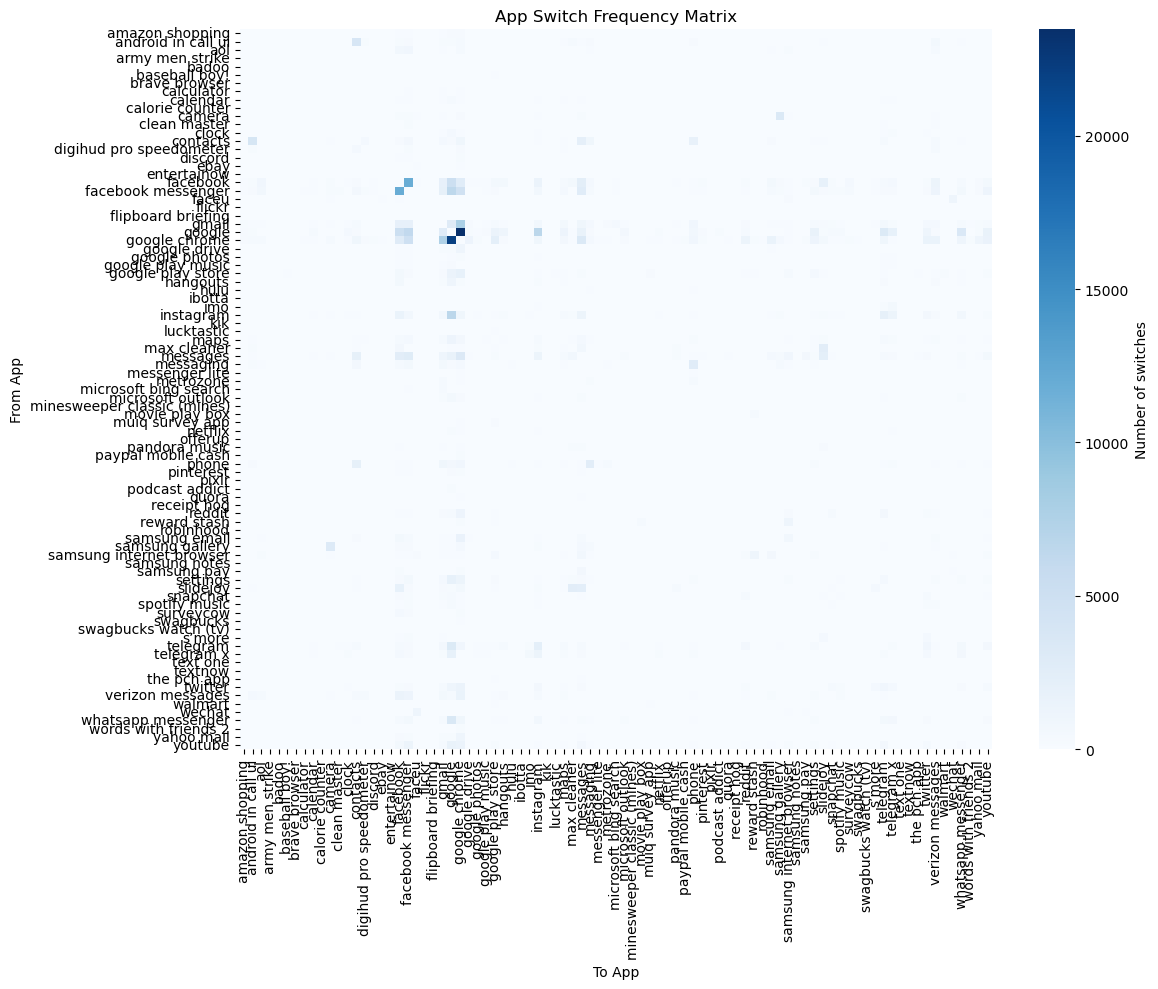

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('../data/cleaned/LSAPP_Processed.csv')

# Only keep relevant columns
df = df[['user_id', 'session_id', 'interaction_id', 'app_name', 'timestamp']]

# Sort by user, session, and interaction to ensure order
df = df.sort_values(['user_id', 'session_id', 'interaction_id'])

# Get all unique app names
apps = df['app_name'].unique()
apps_sorted = sorted(apps)
app_to_idx = {app: idx for idx, app in enumerate(apps_sorted)}

# Initialize transition matrix
n_apps = len(apps_sorted)
transition_matrix = np.zeros((n_apps, n_apps), dtype=int)

# For each user, session, get the sequence of apps and count transitions
for (user, session), group in df.groupby(['user_id', 'session_id']):
    app_sequence = group['app_name'].tolist()
    for i in range(len(app_sequence) - 1):
        from_app = app_sequence[i]
        to_app = app_sequence[i+1]
        if from_app != to_app:  # Only count switches, not repeats
            from_idx = app_to_idx[from_app]
            to_idx = app_to_idx[to_app]
            transition_matrix[from_idx, to_idx] += 1

# Plot the matrix
plt.figure(figsize=(12, 10))
sns.heatmap(transition_matrix, 
            xticklabels=apps_sorted, 
            yticklabels=apps_sorted, 
            cmap='Blues', 
            annot=False, 
            fmt='d',
            cbar_kws={'label': 'Number of switches'})
plt.xlabel('To App')
plt.ylabel('From App')
plt.title('App Switch Frequency Matrix')
plt.tight_layout()
plt.show()


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from matplotlib.colors import LogNorm

from ipywidgets import interact, FloatSlider, IntSlider, fixed

# Load the data
df = pd.read_csv('../data/cleaned/LSAPP_Processed.csv')

# Only keep relevant columns
df = df[['user_id', 'session_id', 'interaction_id', 'app_name', 'timestamp']]

# Sort by user, session, and interaction to ensure order
df = df.sort_values(['user_id', 'session_id', 'interaction_id'])

# Get top 80 most used apps for readability
top_apps = df['app_name'].value_counts().head(40).index
df_filtered = df[df['app_name'].isin(top_apps)]

# Create transition matrix
app_to_idx = {app: idx for idx, app in enumerate(top_apps)}
transition_matrix = np.zeros((len(top_apps), len(top_apps)), dtype=int)

# Count transitions
for (user, session), group in df_filtered.groupby(['user_id', 'session_id']):
    app_sequence = group['app_name'].tolist()
    for i in range(len(app_sequence) - 1):
        from_app = app_sequence[i]
        to_app = app_sequence[i+1]
        if from_app != to_app:  # Only count switches
            from_idx = app_to_idx[from_app]
            to_idx = app_to_idx[to_app]
            transition_matrix[from_idx, to_idx] += 1

# Create undirected network graph for single connection between pairs
G = nx.Graph()

# Add edges with summed weights (combine both directions)
for i in range(len(top_apps)):
    for j in range(i+1, len(top_apps)):
        weight_ij = transition_matrix[i, j]
        weight_ji = transition_matrix[j, i]
        total_weight = weight_ij + weight_ji
        if total_weight > 0:
            G.add_edge(top_apps[i], top_apps[j], weight=total_weight)

# Interactive plotting function
def plot_app_transition_network(
    node_scale=0.1,
    edge_scale=0.5,
    min_edge_width=1.0,
    font_size=8,
    k=6.0,
    iterations=50,
    figsize_x=16,
    figsize_y=12
):
    fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))
    pos = nx.spring_layout(G, k=k, iterations=iterations, seed=42)

    # Node sizes based on total usage
    node_sizes = [df[df['app_name'] == app].shape[0] * node_scale for app in G.nodes()]

    # Edge weights for thickness
    def scale_width(w, min_width=min_edge_width, scale=edge_scale):
        return max(min_width, w * scale)

    edge_weights = [scale_width(G[u][v]['weight']) for u, v in G.edges()]
    edge_freqs = [G[u][v]['weight'] for u, v in G.edges()]

    # Normalize edge frequencies for colormap with logarithmic scaling
    if edge_freqs:
        norm = LogNorm(vmin=min(edge_freqs), vmax=max(edge_freqs))
        cmap = plt.cm.viridis_r
        # Compute edge colors and alpha (opacity) based on strength
        edge_colors = []
        edge_alphas = []
        min_freq = min(edge_freqs)
        max_freq = max(edge_freqs)
        # To avoid division by zero if all weights are the same
        freq_range = max_freq - min_freq if max_freq > min_freq else 1.0
        for w in edge_freqs:
            color = cmap(norm(w))
            # Make weaker connections more transparent (lower alpha) using the same logarithmic scale as color
            # Strongest connection: alpha=1, weakest: alpha=0.2
            # Use normalized value from LogNorm for alpha scaling
            normed = norm(w)
            alpha = 0.2 + 0.8 * normed  # normed is already log-scaled between 0 and 1
            # Replace the alpha channel in the RGBA tuple
            color_with_alpha = color[:3] + (alpha,)
            edge_colors.append(color_with_alpha)
            edge_alphas.append(alpha)
    else:
        edge_colors = 'gray'
        edge_alphas = [1.0 for _ in G.edges()]

    # Draw nodes and labels
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightblue', ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=font_size, font_weight='bold', ax=ax)

    # Draw edges with colors based on weight and alpha for opacity
    # Since networkx does not support per-edge alpha directly, we draw each edge individually
    if edge_freqs:
        for (edge, width, color) in zip(G.edges(), edge_weights, edge_colors):
            nx.draw_networkx_edges(
                G, pos,
                edgelist=[edge],
                width=width,
                edge_color=[color],
                arrows=False,
                ax=ax
            )
    else:
        nx.draw_networkx_edges(
            G, pos,
            width=edge_weights,
            edge_color=edge_colors,
            arrows=False,
            ax=ax
        )

    # Add colorbar for edge frequency
    if edge_freqs:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, shrink=0.7, pad=0.03)
        cbar.set_label('Transition Frequency (log scale, sum of both directions)')
        # Add note about opacity
        cbar.ax.text(1.1, -0.1, "Opacity = connection strength", transform=cbar.ax.transAxes, fontsize=8, va='top')

    ax.set_title('App Transition Network\n(Node size = usage, Edge color/thickness/opacity = transition frequency)')
    ax.axis('off')
    plt.tight_layout()
    plt.show()

    # Print some statistics
    print(f"Number of nodes (apps): {G.number_of_nodes()}")
    print(f"Number of edges (unique app pairs): {G.number_of_edges()}")
    print(f"Most connected app: {max(G.degree, key=lambda x: x[1])[0]}")
    print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")

# Interactive sliders for visual parameters
interact(
    plot_app_transition_network,
    node_scale=FloatSlider(value=0.07, min=0.01, max=1.0, step=0.01, description='Node scale'),
    edge_scale=FloatSlider(value=0.001, min=0.001, max=0.02, step=0.001, description='Edge scale'),
    min_edge_width=FloatSlider(value=1.0, min=0.0, max=10.0, step=0.1, description='Min edge width'),
    font_size=IntSlider(value=8, min=4, max=20, step=1, description='Font size'),
    k=FloatSlider(value=6.0, min=0.1, max=20.0, step=1.0, description='Layout k'),
    iterations=IntSlider(value=50, min=10, max=200, step=1, description='Layout iters'),
    figsize_x=IntSlider(value=16, min=6, max=24, step=1, description='Fig width'),
    figsize_y=IntSlider(value=12, min=4, max=20, step=1, description='Fig height')
)

interactive(children=(FloatSlider(value=0.07, description='Node scale', max=1.0, min=0.01, step=0.01), FloatSl…

<function __main__.plot_app_transition_network(node_scale=0.1, edge_scale=0.5, min_edge_width=1.0, font_size=8, k=6.0, iterations=50, figsize_x=16, figsize_y=12)>

In [34]:
import json

# Build app usage counts and transition counts from the variables already defined above
# (df_filtered, top_apps, transition_matrix, app_to_idx)

# App usage counts for filtered apps
app_usage_counts = df_filtered['app_name'].value_counts().to_dict()

# Transition counts as a dict: (from_app, to_app) -> count
transition_counts = {}
for i, from_app in enumerate(top_apps):
    for j, to_app in enumerate(top_apps):
        if i != j and transition_matrix[i, j] > 0:
            transition_counts[(from_app, to_app)] = int(transition_matrix[i, j])

def export_graph_data(filename="app_transition_network.json", node_scale=0.07, edge_scale=0.001):
    """
    Export the app transition network's node sizes and edge weights to a JSON file.
    This can be used for interactive HTML graph visualization later.
    """
    # Build directed graph for export
    G = nx.DiGraph()
    for app, count in app_usage_counts.items():
        G.add_node(app, size=count * node_scale)
    for (src, dst), freq in transition_counts.items():
        G.add_edge(src, dst, weight=freq * edge_scale)

    # Prepare data for export
    export_data = {
        "nodes": [
            {
                "id": node,
                "size": G.nodes[node]["size"],
                "raw_count": app_usage_counts[node]
            }
            for node in G.nodes
        ],
        "edges": [
            {
                "source": src,
                "target": dst,
                "weight": G.edges[src, dst]["weight"],
                "raw_freq": transition_counts[(src, dst)]
            }
            for src, dst in G.edges
        ]
    }

    with open(filename, "w") as f:
        json.dump(export_data, f, indent=2)
    print(f"Exported graph data to {filename}")

# Example usage:
export_graph_data("app_transition_network.json", node_scale=0.07, edge_scale=0.001)


Exported graph data to app_transition_network.json
